## Le Modèle CBOW

In [ ]:
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## dataset

In [186]:
sentences = """الذكاء الاصطناعي هو مجال يهتم بتطوير الأنظمة التي يمكنها أداء المهام التي تتطلب عادةً الذكاء البشري.
تتضمن هذه المهام مثل التعرف على الصور، معالجة اللغة الطبيعية، والتنبؤ. يعمل الذكاء الاصطناعي على تحسين الكفاءة وجودة العمل في مختلف الصناعات."""

### Clean Data

In [187]:
# remove special characters
sentences = re.sub('[^\u0621-\u064A\s]', ' ', sentences) 

custom_stop_words = [
    "هذا", "في", "على", "هو", "هي", "من", "ما", "إلى", "أن", "عن", "و", "لا"
]
words = word_tokenize(sentences)
filtered_words = [word for word in words if word not in custom_stop_words]
# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()
sentences = " ".join(filtered_words)

In [188]:
sentences

'الذكاء الاصطناعي مجال يهتم بتطوير الأنظمة التي يمكنها أداء المهام التي تتطلب عادة الذكاء البشري تتضمن هذه المهام مثل التعرف الصور معالجة اللغة الطبيعية والتنبؤ يعمل الذكاء الاصطناعي تحسين الكفاءة وجودة العمل مختلف الصناعات'

In [189]:
sentences

'الذكاء الاصطناعي مجال يهتم بتطوير الأنظمة التي يمكنها أداء المهام التي تتطلب عادة الذكاء البشري تتضمن هذه المهام مثل التعرف الصور معالجة اللغة الطبيعية والتنبؤ يعمل الذكاء الاصطناعي تحسين الكفاءة وجودة العمل مختلف الصناعات'

## vocabulary

In [190]:
words = sentences.split()
vocab = set(words)

In [191]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

### Dictionaries

In [192]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

### Data bags

In [193]:
# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['الذكاء', 'الاصطناعي', 'يهتم', 'بتطوير'], 'مجال'), (['الاصطناعي', 'مجال', 'بتطوير', 'الأنظمة'], 'يهتم'), (['مجال', 'يهتم', 'الأنظمة', 'التي'], 'بتطوير'), (['يهتم', 'بتطوير', 'التي', 'يمكنها'], 'الأنظمة'), (['بتطوير', 'الأنظمة', 'يمكنها', 'أداء'], 'التي')]


### Embeddings

In [194]:
embeddings =  np.random.random_sample((vocab_size, embed_dim))

### Linear Model

In [195]:
def linear(m, theta):
    w = theta
    return m.dot(w)

### Log softmax + NLLloss = Cross Entropy

In [196]:
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

In [197]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [198]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- out + softmax) / logits.shape[0]

### Forward function

In [199]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    
    return m, n, o

### Backward function

In [200]:
def backward(preds, theta, target_idxs):
    m, n, o = preds
    
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    
    return dw

### Optimize function

In [201]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

## training

In [202]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [203]:
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
        
     
    epoch_losses[epoch] = losses

### Plot loss/epoch

Text(0, 0.5, 'Losses')

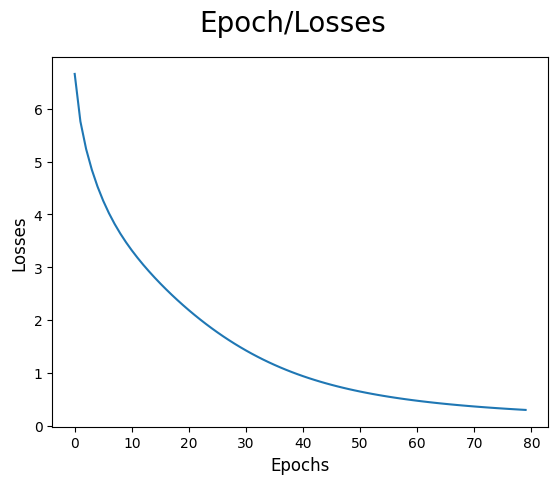

In [204]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

### Predict function

In [205]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    
    return word

In [219]:
# (['الاصطناعي', 'مجال', 'بتطوير', 'الأنظمة'], 'يهتم')
context = ['الأنظمة', 'بتطوير', 'مجال', 'الاصطناعي']
context_reordered = context[::-1]
predict(context_reordered)

'يهتم'

### Accuracy

In [220]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1
            
    return (1 - (wrong / len(data)))

In [221]:
accuracy()

1.0